In [83]:
import numpy as np 
import pandas as pd 

import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset



from timm.models.vision_transformer import VisionTransformer, Block
import timm

from tqdm import tqdm

import copy
import random
import gc
from itertools import count


import math

from matplotlib.colors import ListedColormap




# load data (most code repurposed from original dataset release by Fantine Huot)

In [2]:
# inspect the data
# Load the TFRecord dataset
tfrecord_path = '/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_00.tfrecord'
raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

# Read a single example
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    # Print feature keys
    print("Available features:")
    for key in example.features.feature.keys():
        print(key)


Available features:
vs
th
population
tmmx
PrevFireMask
elevation
sph
pr
pdsi
erc
FireMask
NDVI
tmmn


I0000 00:00:1747109723.810013      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747109723.810702      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [4]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [5]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [6]:
BATCH_SIZE = 32
SAMPLE_SIZE = 64

train_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train*', 
    data_size=64, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

validation_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_eval*', 
    data_size=64, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

test_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_test*',
    data_size=64, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

In [7]:
for x, y in train_dataset.take(1):
    print(x.shape, y.shape)

for x, y in validation_dataset.take(1):
    print(x.shape, y.shape)

(32, 64, 64, 12) (32, 64, 64, 1)
(32, 64, 64, 12) (32, 64, 64, 1)


# convert to torch 

In [8]:


class TFToTorchDataset(Dataset):
    def __init__(self, tf_dataset, clean=False):
        self.samples = []
        for x, y in tf_dataset.as_numpy_iterator():
            for i in range(x.shape[0]):
                # Convert x: (32, 32, 12) → (12, 32, 32)
                x_i = tf.transpose(x[i], perm=[2, 0, 1]).numpy()
                # Convert y: (32, 32, 1) → (1, 32, 32)
                y_i = tf.transpose(y[i], perm=[2, 0, 1]).numpy()
                
                if clean:
                    if (y_i == -1).any():
                        continue  # Skip this sample
                self.samples.append((
                    torch.tensor(x_i, dtype=torch.float32),
                    torch.tensor(y_i, dtype=torch.float32)
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [9]:
torch_dataset = TFToTorchDataset(train_dataset, clean=True)
train_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=32, shuffle=True)

torch_dataset_val =  TFToTorchDataset(validation_dataset, clean=True)
val_loader = torch.utils.data.DataLoader(torch_dataset_val, batch_size=32, shuffle=True)



In [33]:
torch_dataset_test = TFToTorchDataset(test_dataset, clean=True)
test_loader = torch.utils.data.DataLoader(torch_dataset_test, batch_size=32, shuffle=True)


In [89]:
total = 0
for dataset in [torch_dataset, torch_dataset_val, torch_dataset_test]:
    print(len(dataset))
    total += len(dataset)
print(total)

10506
1340
1112
12958


In [10]:
N = 5   
dataiter = iter(train_loader)

image_list = []
label_list = []
#assume batch size equal to 1, otherwise divide N by batch size
for i in range(0, N): 
  image, label = next(dataiter)
  image_list.append(image)
  label_list.append(label)

64


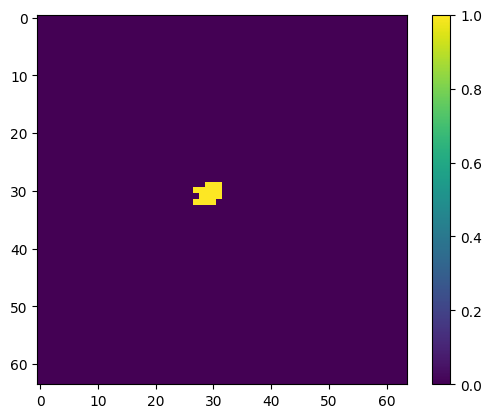

In [11]:
print(len(label_list[0][0][0][0]))
# print(label_list[0][0])
plt.imshow(label_list[4][0][0], cmap='viridis', interpolation='nearest')
plt.colorbar()  
plt.show()


# HELPER FUNCTIONS

In [12]:

def show_prediction(model, val_loader):
    model.eval()
    with torch.no_grad():
        x_val, y_val = next(iter(val_loader))
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_val = (y_val == 1).float()

        pred = model(x_val)
        pred_bin = (pred > 0.5).float()

        # Show first sample
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_val[0, 11].cpu(), cmap='gray')
        axs[0].set_title("Previous Fire Mask")
        axs[1].imshow(y_val[0, 0].cpu(), cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(pred_bin[0, 0].cpu(), cmap='gray')
        axs[2].set_title("Prediction")
        for ax in axs:
            ax.axis('off')
        plt.show()


In [13]:
def compute_iou(pred, target, threshold=0.5, eps=1e-6):
    pred_bin = (pred > threshold).float()
    target_bin = (target > 0.5).float()

    intersection = (pred_bin * target_bin).sum(dim=(1, 2, 3))
    union = (pred_bin + target_bin - pred_bin * target_bin).sum(dim=(1, 2, 3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def compute_accuracy(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    correct = (pred_bin == target).float()
    return correct.mean().item()


In [14]:
def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    correct, total = 0, 0
    intersection, union = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = torch.sigmoid(model(X)) > threshold
            correct += (pred == y).sum().item()
            total += torch.numel(y)
            intersection += (pred & (y > 0.5)).sum().item()
            union += ((pred | (y > 0.5))).sum().item()
    acc = correct / total
    iou = intersection / union if union else 0
    print(f"Pixel Accuracy: {acc:.4f}, IoU: {iou:.4f}")


In [15]:

def compute_pos_weight(data_loader, device):
    total_positives = 0
    total_negatives = 0

    for _, y in data_loader:
        y = y.to(device)
        total_positives += (y == 1).sum().item()
        total_negatives += (y == 0).sum().item()

    if total_positives == 0:
        raise ValueError("No positive samples found in dataset.")
    
    pos_weight = total_negatives / total_positives
    return torch.tensor([pos_weight], dtype=torch.float32, device=device)



In [106]:
def show_best_and_worst_predictions(model, val_loader, num_examples=2, device='cuda', feature_names=None):
    model.eval()
    ious = []
    examples = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_val = (y_val == 1).float()

            pred = model(x_val)
            pred_bin = (pred > 0.5).float()

            for i in range(x_val.size(0)):
                iou = compute_iou(torch.sigmoid(pred[i].unsqueeze(0)), y_val[i].unsqueeze(0))

                ious.append(iou)
                examples.append({
                    "input": x_val[i].detach().cpu(),
                    "gt": y_val[i].detach().cpu(),
                    "pred": pred_bin[i].detach().cpu(),
                    "iou": iou
                })

    # Sort by IoU
    sorted_examples = sorted(examples, key=lambda ex: ex["iou"])
    worst_examples = sorted_examples[1:1+2*num_examples:2]
    best_examples = sorted_examples[-2*num_examples::2]

    def plot_examples_grid(examples, feature_names=None, normalize_input=True, title="Examples"):
        fire_cmap = ListedColormap([
            '#000000',  # -1 → black
            '#808080',  #  0 → gray
            '#ff7f0e',  #  1 → orange 
        ])

        num_examples = len(examples)
        num_feats = examples[0]["input"].shape[0]
        total_panels = num_feats + 2  # inputs + GT + prediction
    
        fig, axs = plt.subplots(num_examples, total_panels, figsize=(2.2 * total_panels, 2.5 * num_examples),
                                gridspec_kw=dict(wspace=0.05, hspace=0.1))
    
        if num_examples == 1:
            axs = axs[None, :]  # ensure 2D indexing even with one example
    
        for row_idx, ex in enumerate(examples):
            inp = ex["input"]
            gt = ex["gt"][0]
            pred = ex["pred"][0]
            iou = ex["iou"]
    
            for col_idx in range(total_panels):
                ax = axs[row_idx, col_idx]
                if col_idx < num_feats:
                    img = inp[col_idx]
                    if normalize_input:
                        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
                    if col_idx == num_feats - 1:  # PrevFireMask
                        ax.imshow(img, cmap=fire_cmap, vmin=-1, vmax=1)
                    else:
                        ax.imshow(img, cmap='viridis')

                elif col_idx == num_feats:
                    ax.imshow(gt, cmap=fire_cmap, vmin=-1, vmax=1)
                elif col_idx == num_feats + 1:
                    ax.imshow(pred, cmap=fire_cmap, vmin=-1, vmax=1)

                    ax.set_title(f"IoU: {iou:.2f}", fontsize=10)
    
                if row_idx == 0:
                    # Top row: show feature titles
                    if col_idx < num_feats:
                        label = feature_names[col_idx] if feature_names else f"Input {col_idx}"
                    elif col_idx == num_feats:
                        label = "Ground Truth"
                    else:
                        label = "Prediction"
                    ax.set_title(label, fontsize=12)
    
                ax.axis("off")

        fig.suptitle(title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        plt.savefig(f"{title}_jpg", dpi=300, bbox_inches='tight')
        
        plt.show()


    plot_examples_grid(worst_examples, title="Worst Examples", feature_names = feature_names)

    plot_examples_grid(best_examples, title="Best Examples", feature_names = feature_names)


# TRAINING LOOP

In [43]:
def train_model(model, train_dataset, val_dataset, params, device):
    """
    A reusable training loop that dynamically creates components based on hyperparameter tuning parameters.

    Args:
        model (torch.nn.Module): The model to train (e.g., U-Net or Vision Transformer).
        train_dataset (Dataset): The training dataset.
        val_dataset (Dataset): The validation dataset.
        params (dict): Dictionary containing hyperparameters (e.g., learning rate, batch size, optimizer type).
        device (torch.device): Device to train on (e.g., 'cuda' or 'cpu').
        num_epochs (int): Number of epochs to train for.

    Returns:
        dict: A dictionary containing training and validation losses, IoU, and accuracy for each epoch.
    """

    # === Create DataLoaders ===
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=params["batch_size"], shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=params["batch_size"], shuffle=False
    )

    # === Define Optimizer ===
    if params["optimizer"] == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    elif params["optimizer"] == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    elif params["optimizer"] == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"], momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {params['optimizer']}")

    num_epochs = params.get("num_epochs", 10)

    # === Define Loss Function ===
    
    # pos_weight = params.get("pos_weight", 0.85 / 0.15) 
    pos_weight = compute_pos_weight(train_loader, device)
    print(pos_weight)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    # pos_weight = torch.tensor([25.0], device=device) 
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


    best_model_wts = copy.deepcopy(model.state_dict())
    # best_model_wts = copy.deepcopy(model.module.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience=5
    min_delta=0


    # === Training Loop ===
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_iou": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        # === Training ===
        model.train()

        train_loss = 0.0

        for x_batch, y_batch in tqdm(train_loader):

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            # outputs = model(x_batch)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x_batch.size(0)

            # Delete temporary tensors
            del x_batch, y_batch, outputs, loss
            # torch.cuda.empty_cache()


        train_loss /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)

        # === Validation ===
        model.eval()
        val_loss = 0.0
        total_iou = 0.0
        total_acc = 0.0
        n_samples = 0

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)

                # Forward pass
                # outputs = model(x_val)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * x_val.size(0)

                # Metrics
                batch_iou = compute_iou(torch.sigmoid(outputs), y_val)
                batch_acc = compute_accuracy(torch.sigmoid(outputs), y_val)

                total_iou += batch_iou * x_val.size(0)
                total_acc += batch_acc * x_val.size(0)
                n_samples += x_val.size(0)

                # Delete temporary tensors
                del x_val, y_val, outputs, loss
                # torch.cuda.empty_cache()


        val_loss /= len(val_loader.dataset)
        mean_iou = total_iou / n_samples
        mean_acc = total_acc / n_samples

        history["val_loss"].append(val_loss)
        history["val_iou"].append(mean_iou)
        history["val_acc"].append(mean_acc)

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"IoU: {mean_iou:.4f} | Acc: {mean_acc:.4f}")

        # === Early stopping ===
        # if val_loss < best_val_loss :
        if val_loss < best_val_loss - min_delta:
            # print("i am here")
            # print("   model.pos_embed shape =", model.patch_embed.pos_embed.shape)

            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}")
                break

    # model.load_state_dict(best_model_wts)
    # # model.module.load_state_dict(best_model_wts)

    del optimizer


    return history , best_model_wts

# HYPER PARAMETER TUNING

In [17]:

EPOCHS = 5
NUM_TRIALS = 10

def random_search(model_type, device, n_trials=NUM_TRIALS):
    best_val_loss = float('inf')
    best_params = None

    for trial in range(n_trials):

        print("trial number ", trial+1)
        if model_type == "unet":
            params = {
                "lr": 10 ** random.uniform(-5, -3),
                "batch_size": random.choice([16, 32, 64]),
                "optimizer": random.choice(["adam", "adamw", "sgd"]),
                "weight_decay": random.choice([0, 1e-4, 1e-3]),
                "num_epochs": 3,
            }
            # val_loss = train_fcn_model(params)
            model = UNet().to(device)
            # model.summary()
        elif model_type == "vit":
            patch_size = random.choice([ 8, 16, 32])
            params = {
                "lr": 10 ** random.uniform(-5, -3),
                "batch_size": random.choice([16, 32, 64]),
                'patch_size': patch_size,
                "optimizer": random.choice(["adam", "adamw", "sgd"]),
                "weight_decay": random.uniform(1e-6, 1e-3),
                "num_epochs": EPOCHS,
            }
            print(params)
            model = ChannelAwareViT(in_channels=12, image_size=64, patch_size=patch_size).to(device)
            model.vit.blocks[0].attn.register_forward_hook(make_attn_hook(model))

            # model = nn.DataParallel(model)  # Wrap for multi-GPU
            # model = model.to(device)

        # history = train_model(model, torch_dataset, torch_dataset_val, params, device)

        history, model_dict = train_model(model, torch_dataset, torch_dataset_val, params, device)


        val_loss = history["val_loss"][-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params  = params.copy()
            best_model = copy.deepcopy(model_dict)

        
        # model = model.module
        del model
        del history

        gc.collect()
        torch.cuda.empty_cache()
    



    return best_params, best_model

# model definition


In [18]:

    
def make_attn_hook(model):
    def hook(module, input, output):
        x = input[0]
        qkv = module.qkv(x)
        B, N, _ = qkv.shape
        C = module.qkv.out_features // 3
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
        q, k, _ = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        model._last_attn_map = attn.detach()  # Attach to the model instance
    return hook


In [19]:
class PatchEmbedWithChannel(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size, image_size=64):
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches_per_channel = (image_size // patch_size) ** 2
        self.total_patches = in_channels * self.num_patches_per_channel

        self.patch_proj = nn.ModuleList([
            nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
            for _ in range(in_channels)
        ])

        # Initialize pos_embed with the expected token count.
        self.pos_embed = nn.Parameter(torch.randn(1, self.total_patches, embed_dim))



    def forward(self, x):  # x: (B, C, H, W)
        B = x.size(0)
        patches = []
        for c in range(self.in_channels):
            out = self.patch_proj[c](x[:, c:c+1])  # (B, D, H', W')
            out = out.flatten(2).transpose(1, 2)   # (B, N_patches, D)
            patches.append(out)

        x = torch.cat(patches, dim=1)  # (B, total_patches, D)

        assert self.pos_embed.shape[1] == x.shape[1], (
            f"Mismatch: pos_embed has {self.pos_embed.shape[1]} tokens, "
            f"but input has {x.shape[1]}"
        )
        return x + self.pos_embed



In [20]:

class ChannelAwareViT(nn.Module):
    def __init__(self, image_size=64, patch_size=8, in_channels=12, embed_dim=384):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        self.patch_embed = PatchEmbedWithChannel(
            in_channels=in_channels,
            patch_size=patch_size,
            embed_dim=embed_dim,
        )

        self.vit = timm.create_model("vit_small_patch16_224", pretrained=False)
        self.vit.patch_embed = nn.Identity()
        self.vit.cls_token = None
        self.vit.pos_embed = None
        self.blocks = self.vit.blocks
        self.norm = self.vit.norm

        self.decoder_fc = nn.Linear(embed_dim, patch_size * patch_size)

    def forward(self, x):
        x = self.patch_embed(x)  # (B, N, D)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return self.decode_patches(x)

    def decode_patches(self, x):
        B, N, D = x.shape
        tokens_per_channel = N // self.in_channels
        spatial_size = int(tokens_per_channel ** 0.5)

        x = self.decoder_fc(x)
        P = self.patch_size
        x = x.view(B, self.in_channels, spatial_size, spatial_size, P, P)
        x = x.permute(0, 1, 2, 4, 3, 5).contiguous()
        x = x.view(B, self.in_channels, spatial_size * P, spatial_size * P)
        x = x.sum(dim=1, keepdim=True)
        return x




In [21]:
def visualize_attention_per_output_pixel(model, input_tensor, pixel_xy):
    """
    Visualizes attention weights for a specific output pixel across input channels.

    Args:
        model: ChannelAwareViT instance with _last_attn_map attached.
        input_tensor: input of shape (1, C=12, 64, 64)
        pixel_xy: tuple of (i, j) output pixel coordinates (in image space)

    Returns:
        List of per-channel attention weights targeting that output location.
    """
    model.eval()
    model._last_attn_map = None  # reset before forward

    with torch.no_grad():
        _ = model(input_tensor)

    attn = model._last_attn_map  # stored via the forward hook
    if attn is None:
        raise RuntimeError("Attention was not captured by the hook.")

    attn_avg = attn.mean(dim=1).squeeze(0)  # (N_tokens, N_tokens)

    out_i, out_j = pixel_xy
    patch_h = patch_w = model.image_size // model.patch_size
    patch_idx = (out_i // model.patch_size) * patch_w + (out_j // model.patch_size)

    tokens_per_channel = patch_h * patch_w
    attn_weights = []
    for c in range(model.in_channels):
        token_index = c * tokens_per_channel + patch_idx
        attn_weights.append(attn_avg[token_index].cpu().numpy())  # shape: (N_tokens,)

    return attn_weights


In [92]:
attn_image_count = 0
def plot_model_attention_for_pixel(model, val_loader, pixel_xy=(32, 32), titles=None, normalize_input=True, save_path=None):
    """
    Visualize all input channels and corresponding attention maps in two rows.

    Args:
        model: ChannelAwareViT with attention hook registered
        val_loader: validation DataLoader
        pixel_xy: (i, j) pixel in output to inspect
        titles: optional list of feature names
        normalize_input: whether to normalize each input for display
        save_path: optional file path to save the figure
    """
    input_tensor, _ = next(iter(val_loader))
    input_tensor = input_tensor[:1].to(next(model.parameters()).device)  # (1, C=12, 64, 64)

    attn_per_channel = visualize_attention_per_output_pixel(model, input_tensor, pixel_xy)
    input_np = input_tensor.squeeze(0).cpu().numpy()
    num_channels = input_np.shape[0]

    patch_h = patch_w = model.image_size // model.patch_size
    tokens_per_channel = patch_h * patch_w

    fig, axs = plt.subplots(2, num_channels, figsize=(2.4 * num_channels, 5), gridspec_kw=dict(wspace=0.05, hspace=0.15))

    for i in range(num_channels):
        # === Input ===
        img = input_np[i]
        if normalize_input:
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        axs[0, i].imshow(img, cmap='gray')
        if titles:
            axs[0, i].set_title(titles[i], fontsize=11)
        axs[0, i].axis('off')

        # === Attention ===
        attn_flat = np.array(attn_per_channel[i][i * tokens_per_channel : (i + 1) * tokens_per_channel])
        attn_map = attn_flat.reshape(1, 1, patch_h, patch_w)
        attn_upsampled = F.interpolate(torch.tensor(attn_map), size=(64, 64), mode='bilinear', align_corners=False)
        attn_img = attn_upsampled.squeeze().cpu().numpy()
        attn_img = (attn_img - attn_img.min()) / (attn_img.max() - attn_img.min() + 1e-6)

        axs[1, i].imshow(attn_img, cmap='viridis')
        axs[1, i].axis('off')

    axs[0, 0].set_ylabel("Input", fontsize=12)
    axs[1, 0].set_ylabel("Attention", fontsize=12)

    plt.suptitle(f"Attention for Output Pixel {pixel_xy}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    global attn_image_count
    attn_image_count += 1
    plt.savefig(f'attention_{attn_image_count}', dpi=300, bbox_inches='tight')

    plt.show()


# hyper parameter search

In [23]:
# last_attn_map = None  # global cache for extracted attention
# attn_weights_cache = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
best_params_vt, best_model_vt = random_search(model_type = "vit", device = device)
# best_params_vt = random_search(model_type = "vit", device = device)


print('BEST PARAMS!!!')
print(best_params_vt)
patch_size = best_params_vt["patch_size"]


cuda
trial number  1
{'lr': 0.00014509808963003923, 'batch_size': 16, 'patch_size': 32, 'optimizer': 'adam', 'weight_decay': 0.0004242168831679107, 'num_epochs': 5}


100%|██████████| 657/657 [00:31<00:00, 21.06it/s]


Epoch 1/5 | Train Loss: 0.8171 | Val Loss: 0.9995 | IoU: 0.0684 | Acc: 0.8590


100%|██████████| 657/657 [00:30<00:00, 21.74it/s]


Epoch 2/5 | Train Loss: 0.6371 | Val Loss: 1.0101 | IoU: 0.0930 | Acc: 0.9017


100%|██████████| 657/657 [00:30<00:00, 21.36it/s]


Epoch 3/5 | Train Loss: 0.5844 | Val Loss: 1.0356 | IoU: 0.0921 | Acc: 0.9002


100%|██████████| 657/657 [00:31<00:00, 21.05it/s]


Epoch 4/5 | Train Loss: 0.5530 | Val Loss: 0.9391 | IoU: 0.0871 | Acc: 0.8819


100%|██████████| 657/657 [00:31<00:00, 20.81it/s]


Epoch 5/5 | Train Loss: 0.5333 | Val Loss: 1.0198 | IoU: 0.0998 | Acc: 0.9036
trial number  2
{'lr': 0.00012300080088880437, 'batch_size': 16, 'patch_size': 16, 'optimizer': 'adamw', 'weight_decay': 0.00026710278131961775, 'num_epochs': 5}


100%|██████████| 657/657 [01:45<00:00,  6.21it/s]


Epoch 1/5 | Train Loss: 0.8141 | Val Loss: 0.9738 | IoU: 0.0711 | Acc: 0.8595


100%|██████████| 657/657 [01:48<00:00,  6.07it/s]


Epoch 2/5 | Train Loss: 0.6237 | Val Loss: 1.0020 | IoU: 0.1054 | Acc: 0.9146


100%|██████████| 657/657 [01:48<00:00,  6.08it/s]


Epoch 3/5 | Train Loss: 0.5604 | Val Loss: 0.9976 | IoU: 0.1156 | Acc: 0.9142


100%|██████████| 657/657 [01:48<00:00,  6.05it/s]


Epoch 4/5 | Train Loss: 0.5273 | Val Loss: 0.9149 | IoU: 0.1058 | Acc: 0.9039


100%|██████████| 657/657 [01:48<00:00,  6.05it/s]


Epoch 5/5 | Train Loss: 0.5007 | Val Loss: 0.9247 | IoU: 0.0965 | Acc: 0.8911
trial number  3
{'lr': 7.347417808424734e-05, 'batch_size': 64, 'patch_size': 16, 'optimizer': 'sgd', 'weight_decay': 0.0006147298048229605, 'num_epochs': 5}


100%|██████████| 165/165 [01:42<00:00,  1.61it/s]


Epoch 1/5 | Train Loss: 1.8315 | Val Loss: 1.9355 | IoU: 0.0187 | Acc: 0.5317


100%|██████████| 165/165 [01:43<00:00,  1.60it/s]


Epoch 2/5 | Train Loss: 1.5705 | Val Loss: 1.7670 | IoU: 0.0203 | Acc: 0.5737


100%|██████████| 165/165 [01:42<00:00,  1.60it/s]


Epoch 3/5 | Train Loss: 1.4361 | Val Loss: 1.6525 | IoU: 0.0219 | Acc: 0.6084


100%|██████████| 165/165 [01:43<00:00,  1.60it/s]


Epoch 4/5 | Train Loss: 1.3385 | Val Loss: 1.5663 | IoU: 0.0236 | Acc: 0.6431


100%|██████████| 165/165 [01:43<00:00,  1.60it/s]


Epoch 5/5 | Train Loss: 1.2623 | Val Loss: 1.4953 | IoU: 0.0253 | Acc: 0.6709
trial number  4
{'lr': 1.2268245807248659e-05, 'batch_size': 32, 'patch_size': 32, 'optimizer': 'sgd', 'weight_decay': 0.0006084661334486754, 'num_epochs': 5}


100%|██████████| 329/329 [00:27<00:00, 11.85it/s]


Epoch 1/5 | Train Loss: 2.1021 | Val Loss: 2.2580 | IoU: 0.0166 | Acc: 0.5041


100%|██████████| 329/329 [00:27<00:00, 11.84it/s]


Epoch 2/5 | Train Loss: 1.8721 | Val Loss: 2.0859 | IoU: 0.0177 | Acc: 0.5074


100%|██████████| 329/329 [00:27<00:00, 11.85it/s]


Epoch 3/5 | Train Loss: 1.7524 | Val Loss: 1.9793 | IoU: 0.0184 | Acc: 0.5110


100%|██████████| 329/329 [00:27<00:00, 11.86it/s]


Epoch 4/5 | Train Loss: 1.6724 | Val Loss: 1.9030 | IoU: 0.0189 | Acc: 0.5150


100%|██████████| 329/329 [00:27<00:00, 11.87it/s]


Epoch 5/5 | Train Loss: 1.6127 | Val Loss: 1.8440 | IoU: 0.0194 | Acc: 0.5192
trial number  5
{'lr': 0.00015087861054547652, 'batch_size': 16, 'patch_size': 8, 'optimizer': 'adamw', 'weight_decay': 0.000966492345231263, 'num_epochs': 5}


100%|██████████| 657/657 [09:32<00:00,  1.15it/s]


Epoch 1/5 | Train Loss: 0.8090 | Val Loss: 0.9910 | IoU: 0.0952 | Acc: 0.9023


100%|██████████| 657/657 [09:44<00:00,  1.12it/s]


Epoch 2/5 | Train Loss: 0.6204 | Val Loss: 0.8535 | IoU: 0.0864 | Acc: 0.8866


100%|██████████| 657/657 [09:38<00:00,  1.14it/s]


Epoch 3/5 | Train Loss: 0.5586 | Val Loss: 0.8304 | IoU: 0.0664 | Acc: 0.8305


100%|██████████| 657/657 [09:30<00:00,  1.15it/s]


Epoch 4/5 | Train Loss: 0.5342 | Val Loss: 0.9080 | IoU: 0.0998 | Acc: 0.9039


100%|██████████| 657/657 [09:30<00:00,  1.15it/s]


Epoch 5/5 | Train Loss: 0.5119 | Val Loss: 0.8755 | IoU: 0.0780 | Acc: 0.8741
trial number  6
{'lr': 4.0171319778863103e-05, 'batch_size': 32, 'patch_size': 16, 'optimizer': 'adam', 'weight_decay': 0.0007065980530960063, 'num_epochs': 5}


100%|██████████| 329/329 [01:45<00:00,  3.13it/s]


Epoch 1/5 | Train Loss: 0.8985 | Val Loss: 0.9529 | IoU: 0.0680 | Acc: 0.8372


100%|██████████| 329/329 [01:45<00:00,  3.12it/s]


Epoch 2/5 | Train Loss: 0.6857 | Val Loss: 0.9409 | IoU: 0.1047 | Acc: 0.8948


100%|██████████| 329/329 [01:45<00:00,  3.11it/s]


Epoch 3/5 | Train Loss: 0.6307 | Val Loss: 0.9543 | IoU: 0.0958 | Acc: 0.8972


100%|██████████| 329/329 [01:45<00:00,  3.11it/s]


Epoch 4/5 | Train Loss: 0.6009 | Val Loss: 0.8708 | IoU: 0.0799 | Acc: 0.8677


100%|██████████| 329/329 [01:45<00:00,  3.12it/s]


Epoch 5/5 | Train Loss: 0.5822 | Val Loss: 0.9737 | IoU: 0.0978 | Acc: 0.8945
trial number  7
{'lr': 0.0002225909570596329, 'batch_size': 32, 'patch_size': 32, 'optimizer': 'adam', 'weight_decay': 0.00010043311105864082, 'num_epochs': 5}


100%|██████████| 329/329 [00:29<00:00, 11.27it/s]


Epoch 1/5 | Train Loss: 0.8210 | Val Loss: 0.9315 | IoU: 0.0789 | Acc: 0.8711


100%|██████████| 329/329 [00:29<00:00, 11.27it/s]


Epoch 2/5 | Train Loss: 0.6062 | Val Loss: 0.9461 | IoU: 0.0881 | Acc: 0.8824


100%|██████████| 329/329 [00:29<00:00, 11.26it/s]


Epoch 3/5 | Train Loss: 0.5581 | Val Loss: 0.9079 | IoU: 0.0788 | Acc: 0.8737


100%|██████████| 329/329 [00:29<00:00, 11.28it/s]


Epoch 4/5 | Train Loss: 0.5226 | Val Loss: 1.0611 | IoU: 0.1073 | Acc: 0.9110


100%|██████████| 329/329 [00:29<00:00, 11.29it/s]


Epoch 5/5 | Train Loss: 0.4892 | Val Loss: 0.8540 | IoU: 0.0798 | Acc: 0.8659
trial number  8
{'lr': 1.558892281079907e-05, 'batch_size': 32, 'patch_size': 16, 'optimizer': 'adamw', 'weight_decay': 0.0008065332313046971, 'num_epochs': 5}


100%|██████████| 329/329 [01:45<00:00,  3.13it/s]


Epoch 1/5 | Train Loss: 1.0255 | Val Loss: 1.0423 | IoU: 0.0457 | Acc: 0.7035


100%|██████████| 329/329 [01:45<00:00,  3.11it/s]


Epoch 2/5 | Train Loss: 0.7922 | Val Loss: 0.9373 | IoU: 0.0670 | Acc: 0.8186


100%|██████████| 329/329 [01:45<00:00,  3.12it/s]


Epoch 3/5 | Train Loss: 0.6887 | Val Loss: 0.9878 | IoU: 0.0918 | Acc: 0.8947


100%|██████████| 329/329 [01:47<00:00,  3.06it/s]


Epoch 4/5 | Train Loss: 0.6470 | Val Loss: 0.9574 | IoU: 0.0981 | Acc: 0.8943


100%|██████████| 329/329 [01:48<00:00,  3.02it/s]


Epoch 5/5 | Train Loss: 0.6189 | Val Loss: 0.8819 | IoU: 0.0912 | Acc: 0.8821
trial number  9
{'lr': 0.00014397874026815513, 'batch_size': 16, 'patch_size': 32, 'optimizer': 'adam', 'weight_decay': 0.00042468034289047196, 'num_epochs': 5}


100%|██████████| 657/657 [00:33<00:00, 19.75it/s]


Epoch 1/5 | Train Loss: 0.8183 | Val Loss: 1.0393 | IoU: 0.0909 | Acc: 0.8955


100%|██████████| 657/657 [00:33<00:00, 19.73it/s]


Epoch 2/5 | Train Loss: 0.6331 | Val Loss: 0.9466 | IoU: 0.0961 | Acc: 0.8861


100%|██████████| 657/657 [00:33<00:00, 19.77it/s]


Epoch 3/5 | Train Loss: 0.5820 | Val Loss: 0.8943 | IoU: 0.0966 | Acc: 0.8832


100%|██████████| 657/657 [00:33<00:00, 19.75it/s]


Epoch 4/5 | Train Loss: 0.5521 | Val Loss: 0.9658 | IoU: 0.0901 | Acc: 0.8950


100%|██████████| 657/657 [00:33<00:00, 19.76it/s]


Epoch 5/5 | Train Loss: 0.5300 | Val Loss: 0.8348 | IoU: 0.0957 | Acc: 0.8664
trial number  10
{'lr': 4.241135244274553e-05, 'batch_size': 16, 'patch_size': 16, 'optimizer': 'sgd', 'weight_decay': 0.00020267171081566316, 'num_epochs': 5}


100%|██████████| 657/657 [01:49<00:00,  5.98it/s]


Epoch 1/5 | Train Loss: 1.7354 | Val Loss: 1.7853 | IoU: 0.0206 | Acc: 0.5797


100%|██████████| 657/657 [01:49<00:00,  5.98it/s]


Epoch 2/5 | Train Loss: 1.3872 | Val Loss: 1.5518 | IoU: 0.0242 | Acc: 0.6581


100%|██████████| 657/657 [01:49<00:00,  5.98it/s]


Epoch 3/5 | Train Loss: 1.2142 | Val Loss: 1.4059 | IoU: 0.0289 | Acc: 0.7160


100%|██████████| 657/657 [01:49<00:00,  6.01it/s]


Epoch 4/5 | Train Loss: 1.1098 | Val Loss: 1.3067 | IoU: 0.0339 | Acc: 0.7371


100%|██████████| 657/657 [01:49<00:00,  6.01it/s]


Epoch 5/5 | Train Loss: 1.0477 | Val Loss: 1.2439 | IoU: 0.0387 | Acc: 0.7421
BEST PARAMS!!!
{'lr': 0.00014397874026815513, 'batch_size': 16, 'patch_size': 32, 'optimizer': 'adam', 'weight_decay': 0.00042468034289047196, 'num_epochs': 5}


# training w best hyperparams

In [40]:
best_params_vt = {'lr': 0.00012300080088880437, 'batch_size': 16, 'patch_size': 16, 'optimizer': 'adamw',
                  'weight_decay': 0.00026710278131961775, 'num_epochs': 30}
patch_size = best_params_vt["patch_size"]

print('BEST PARAMS!!!')
print(best_params_vt)


BEST PARAMS!!!
{'lr': 0.00012300080088880437, 'batch_size': 16, 'patch_size': 16, 'optimizer': 'adamw', 'weight_decay': 0.00026710278131961775, 'num_epochs': 30}


In [41]:
model = ChannelAwareViT(in_channels=12, image_size=64, patch_size=patch_size).to(device)
model.vit.blocks[0].attn.register_forward_hook(make_attn_hook(model))


In [97]:
history, model_dict = train_model(model, torch_dataset, torch_dataset_val, best_params_vt, device)


tensor([82.8183], device='cuda:0')


100%|██████████| 657/657 [01:39<00:00,  6.62it/s]


Epoch 1/30 | Train Loss: 0.5119 | Val Loss: 1.0269 | IoU: 0.1157 | Acc: 0.9129


100%|██████████| 657/657 [01:44<00:00,  6.31it/s]


Epoch 2/30 | Train Loss: 0.4904 | Val Loss: 0.9804 | IoU: 0.1208 | Acc: 0.9183


100%|██████████| 657/657 [01:46<00:00,  6.18it/s]


Epoch 3/30 | Train Loss: 0.4712 | Val Loss: 1.0642 | IoU: 0.1133 | Acc: 0.9191


100%|██████████| 657/657 [01:47<00:00,  6.09it/s]


Epoch 4/30 | Train Loss: 0.4482 | Val Loss: 1.0893 | IoU: 0.1067 | Acc: 0.9115


100%|██████████| 657/657 [01:48<00:00,  6.07it/s]


Epoch 5/30 | Train Loss: 0.4320 | Val Loss: 1.0511 | IoU: 0.1133 | Acc: 0.9088


100%|██████████| 657/657 [01:48<00:00,  6.05it/s]


Epoch 6/30 | Train Loss: 0.4144 | Val Loss: 1.0395 | IoU: 0.1037 | Acc: 0.9036


100%|██████████| 657/657 [01:48<00:00,  6.05it/s]


Epoch 7/30 | Train Loss: 0.3981 | Val Loss: 1.1235 | IoU: 0.1172 | Acc: 0.9196
Early stopping at epoch 7. Best Val Loss: 0.9804


In [98]:
torch.save(model_dict, "another_best_trained_patch_firemask_model_vit.pth")


# analysis of best model

In [99]:
model.load_state_dict(model_dict)

<All keys matched successfully>

In [100]:
evaluate(model, test_loader)


Pixel Accuracy: 0.9191, IoU: 0.1140


/tmp/ipykernel_31/1868714542.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


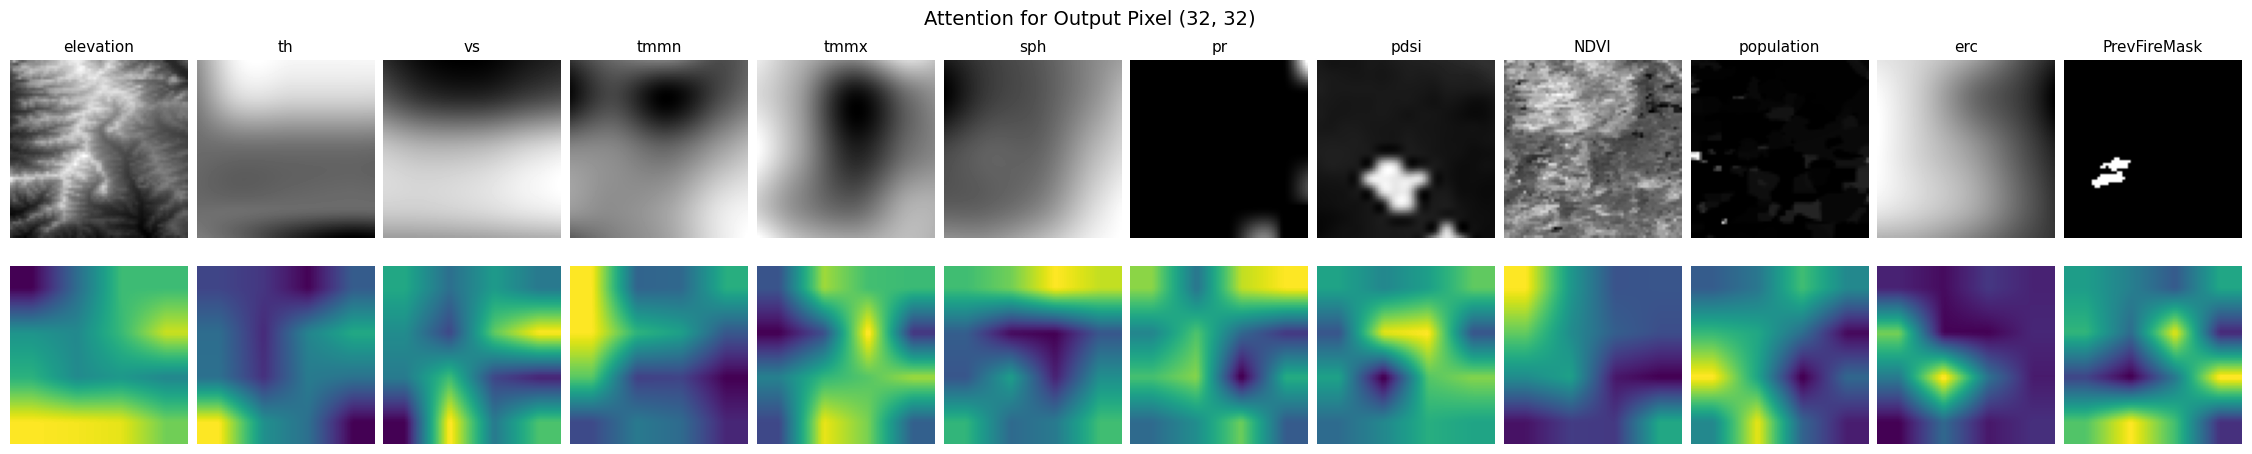

In [108]:
plot_model_attention_for_pixel(model, test_loader, pixel_xy=(32, 32), titles=INPUT_FEATURES)


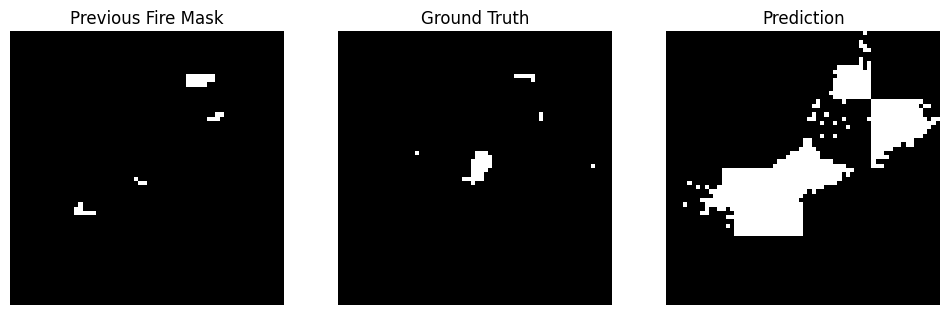

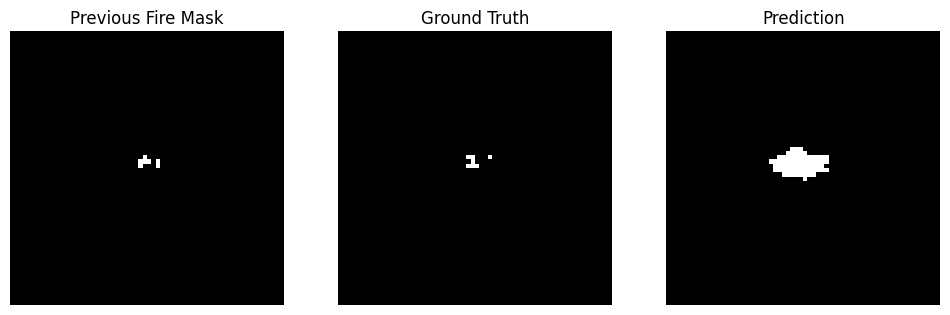

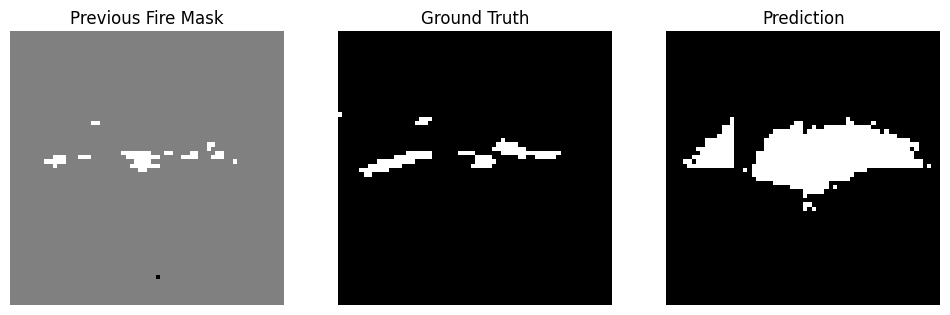

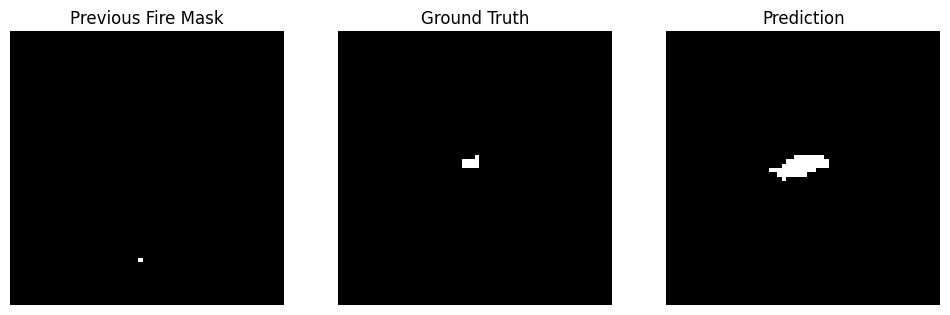

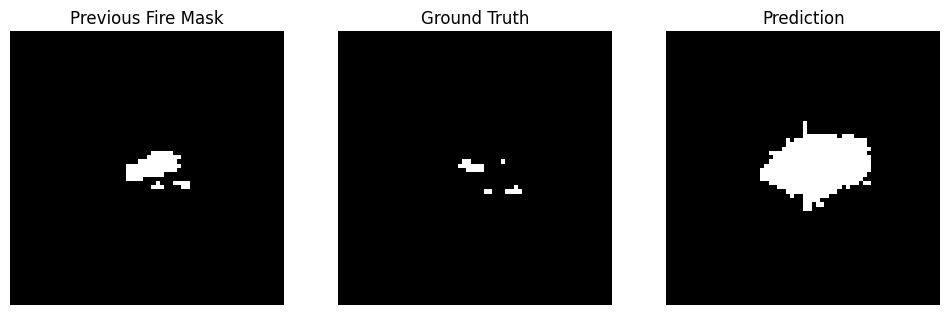

In [102]:
for i in range(5):
    show_prediction(model, test_loader)

/tmp/ipykernel_31/60494863.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


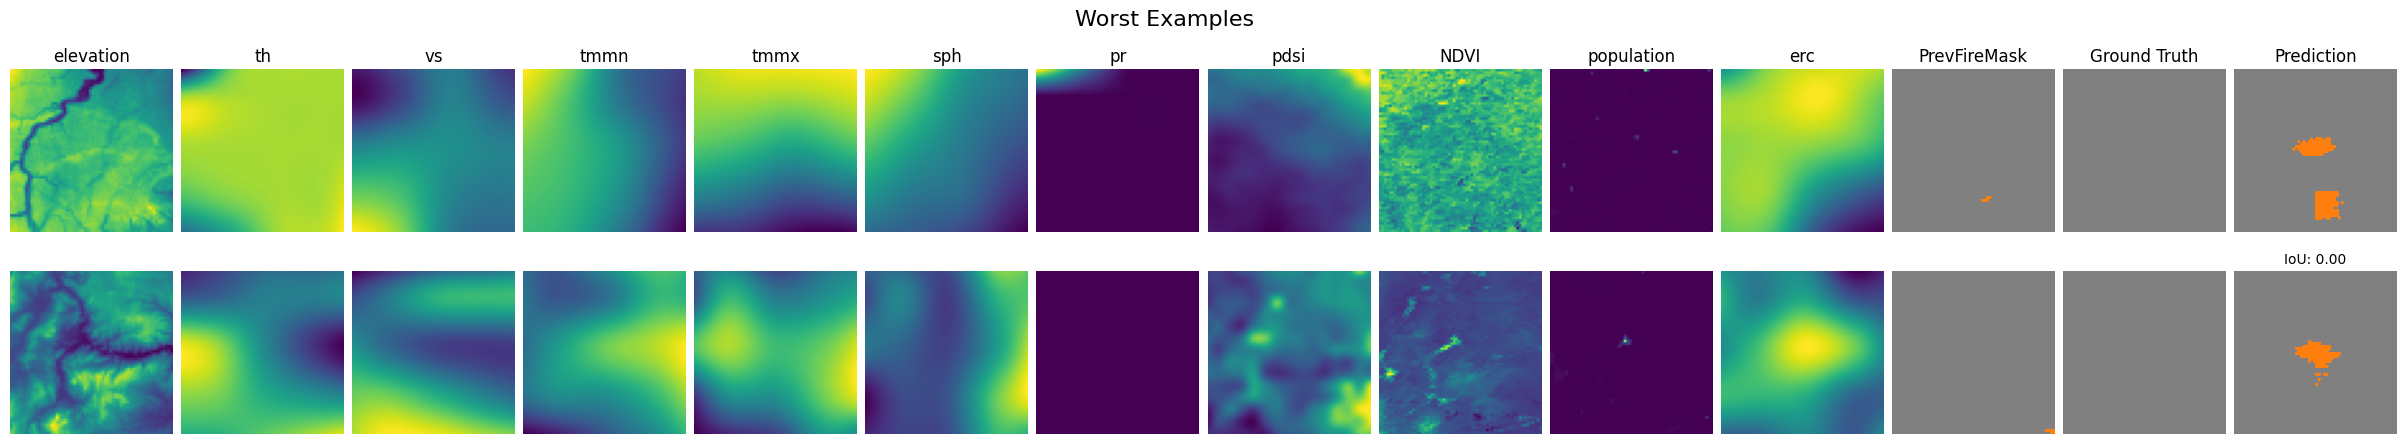

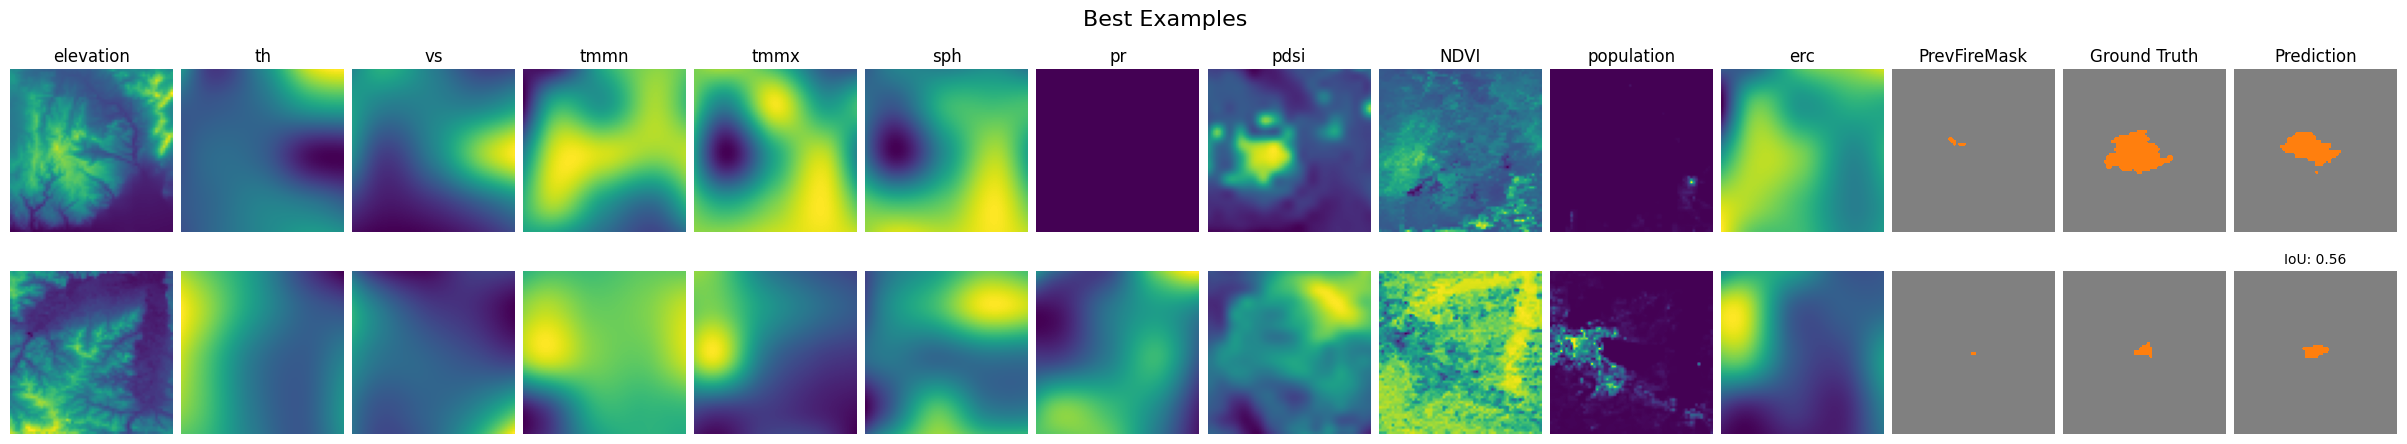

In [107]:
show_best_and_worst_predictions(model, test_loader, device=device, feature_names=INPUT_FEATURES)
